In [1]:
# Summary

# Step 1: Import Python Libraries

In [169]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb 
from lightgbm import LGBMClassifier
import xgboost as XGBClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result


from datetime import datetime
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore')

from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [162]:
# Import fraud detection dataset from Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)
data_df = pd.read_csv('./creditcard.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [157]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# Check for missing data

In [10]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,Amount,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Exploratory Data Analysis

In [86]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Data (Valid = 0, Fraud = 1)",
    marker=dict(color="Blue"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Data (Valid = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=400
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

In [ ]:
# Feature Analysis

In [ ]:
# Transactions over time

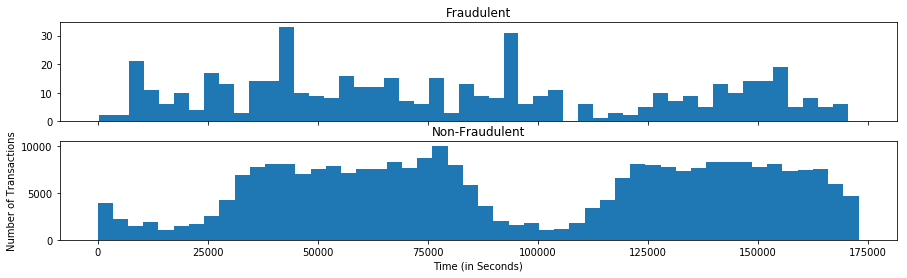

In [148]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [15,4])

ax1.hist(data_df.Time[data_df.Class == 1], bins = 50)
ax1.set_title("Fraudulent")
ax2.hist(data_df.Time[data_df.Class == 0], bins = 50)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

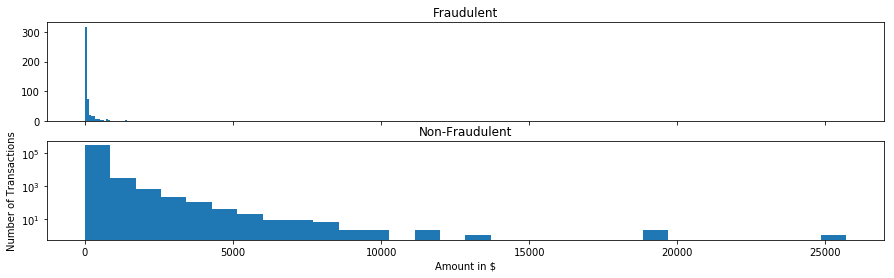

In [149]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [15,4])

ax1.hist(data_df.Amount[data_df.Class == 1], bins = 30)
ax1.set_title("Fraudulent")
ax2.hist(data_df.Amount[data_df.Class == 0], bins = 30)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Amount in $')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

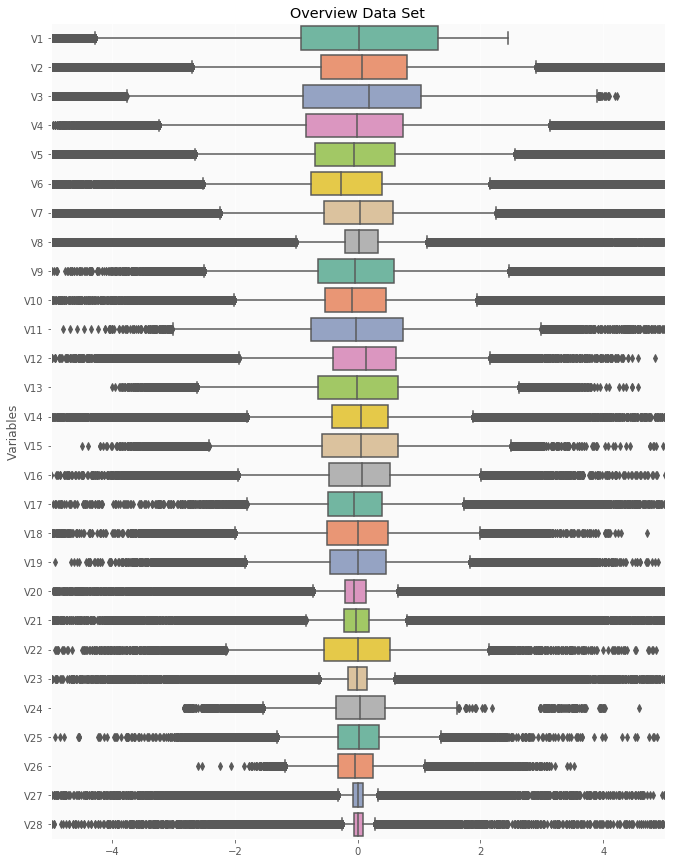

In [150]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-5, 5))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data_df.drop(columns=['Amount', 'Class', 'Time']), 
  orient = 'h', 
  palette = 'Set2')

In [15]:
# Transactions Amount Analysis

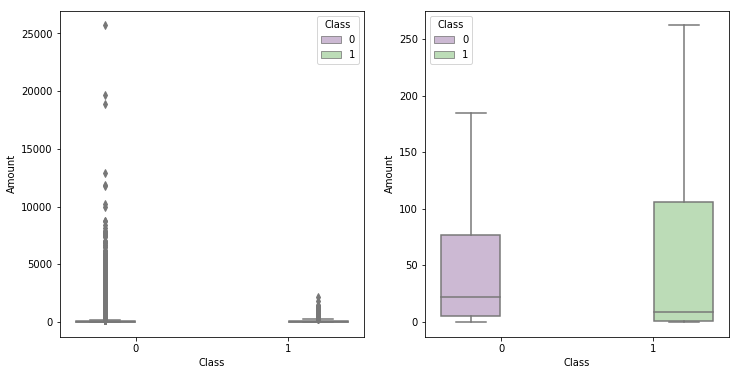

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [ ]:
# Feature Density Plots

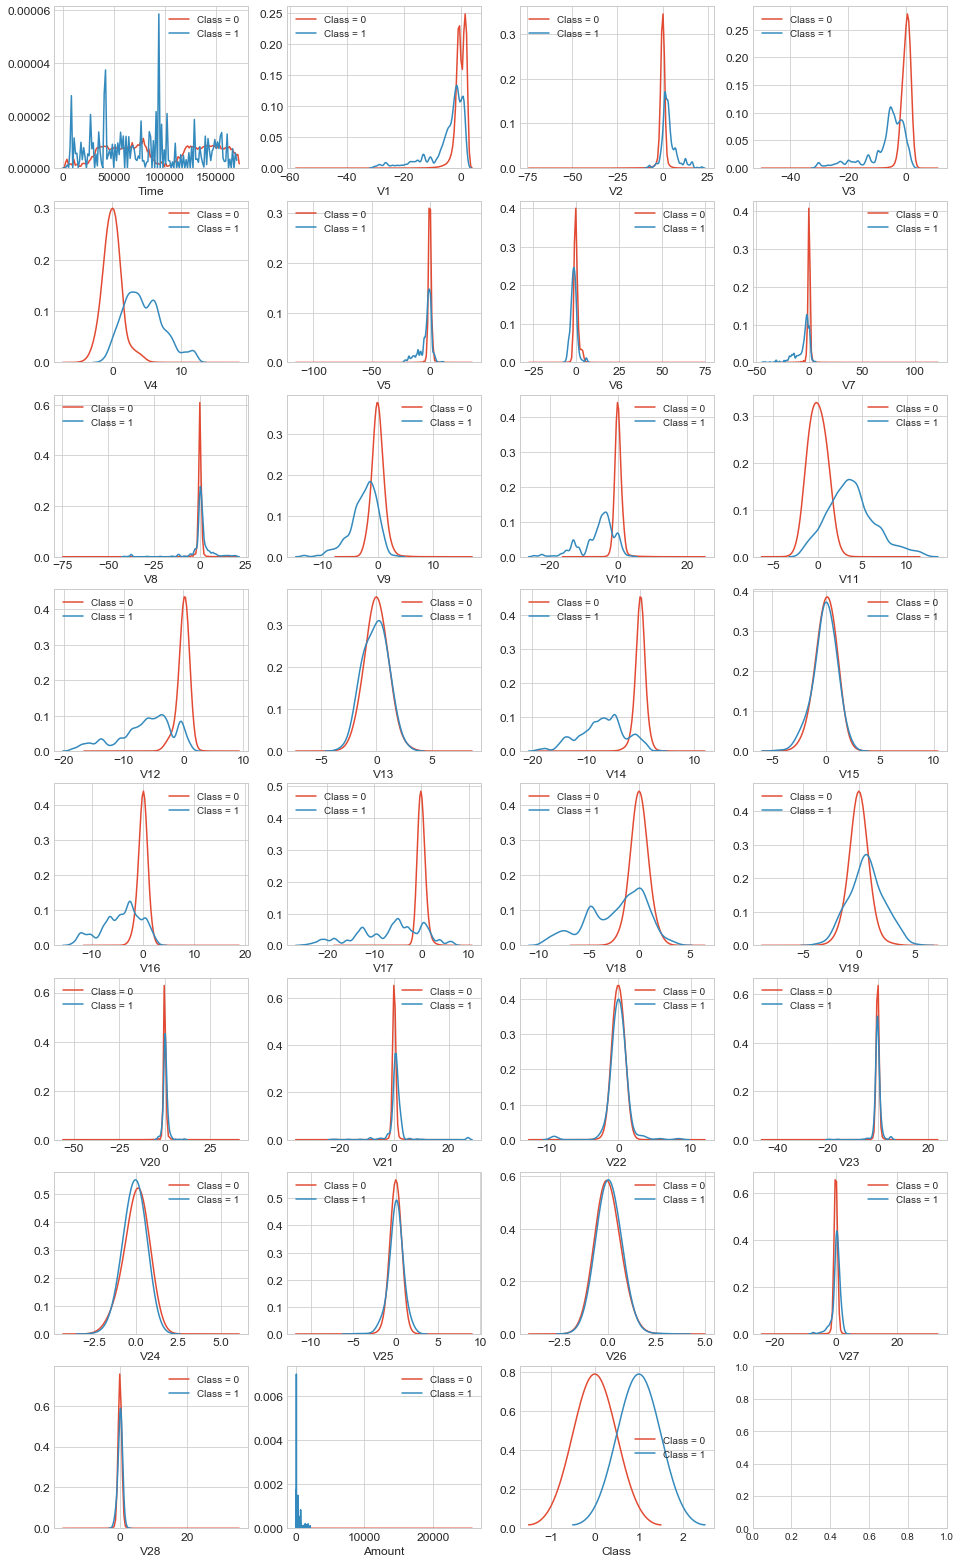

In [45]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

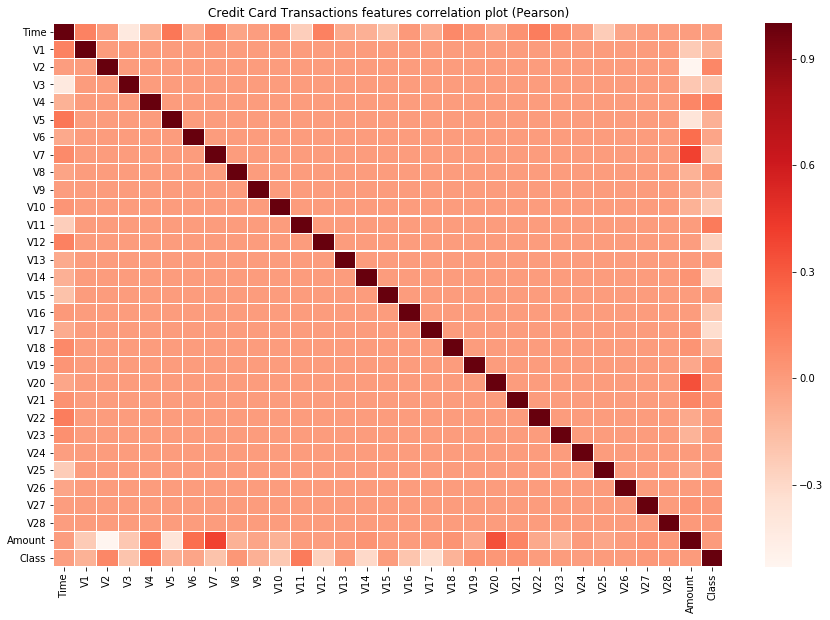

In [97]:
plt.figure(figsize = (15,10))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [42]:
# Feature Correlation

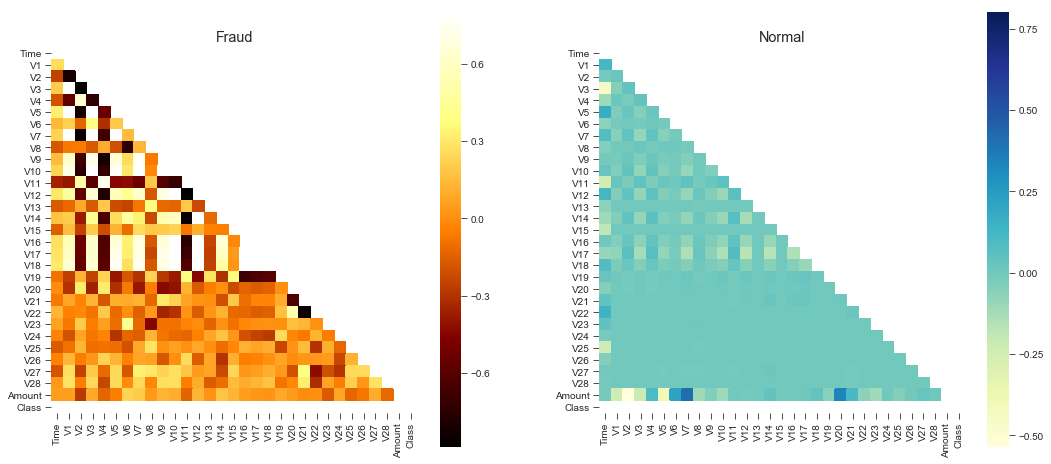

In [44]:
# Correlation matrix 
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 18, 8))
corr = data_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((data_df.loc[data_df['Class'] ==1]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'afmhot', mask=mask);
ax1.set_title('Fraud')
sns.heatmap((data_df.loc[data_df['Class'] ==0]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask);
ax2.set_title('Normal')
plt.show()

In [110]:
# Visualizing the Data with t-SNE
from sklearn.manifold import TSNE

In [106]:
#reload the original dataset
tsne_data = data_df

In [107]:
#Set df2 equal to all of the fraulent and 10,000 normal transactions.
df2 = tsne_data[tsne_data.Class == 1]
df2 = pd.concat([df2, tsne_data[tsne_data.Class == 0].sample(n = 10000)], axis = 0)

In [108]:
#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)

#Set y equal to the target values.
y = df2.ix[:,-1].values

In [111]:
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df2_std)

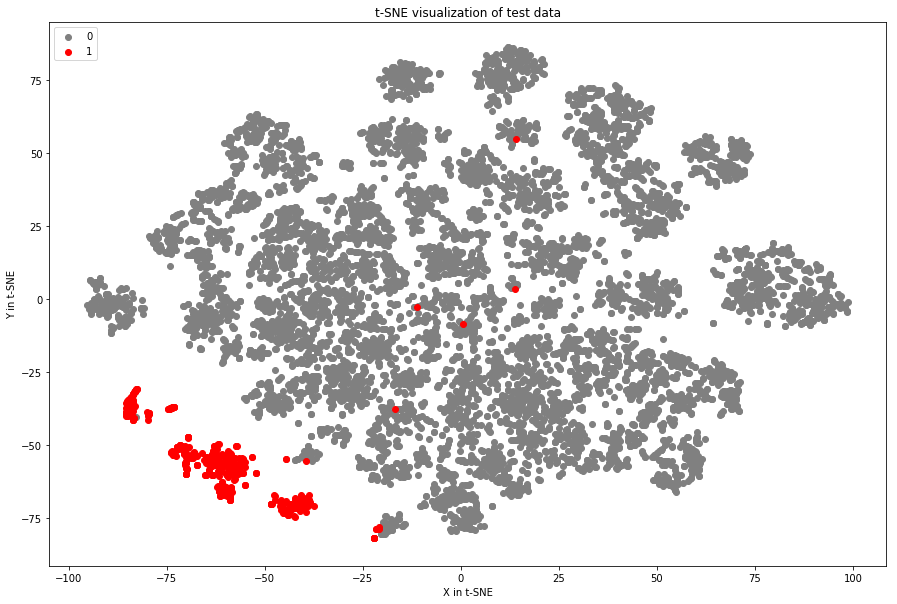

In [115]:
#Build the scatter plot with the two types of transactions.
color_map = {0:'grey', 1:'red'}
plt.figure(figsize = (15,10))
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

In [ ]:
# Prepare Test and Train dataframes

In [ ]:
#Define predictors and target values¶

In [121]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [47]:
#Split data in train, test and validation set

In [122]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [ ]:
# Algorithm 1- Random Forest

In [123]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [124]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [125]:
rf_preds = clf.predict(valid_df[predictors])

In [49]:
# Feature Importance

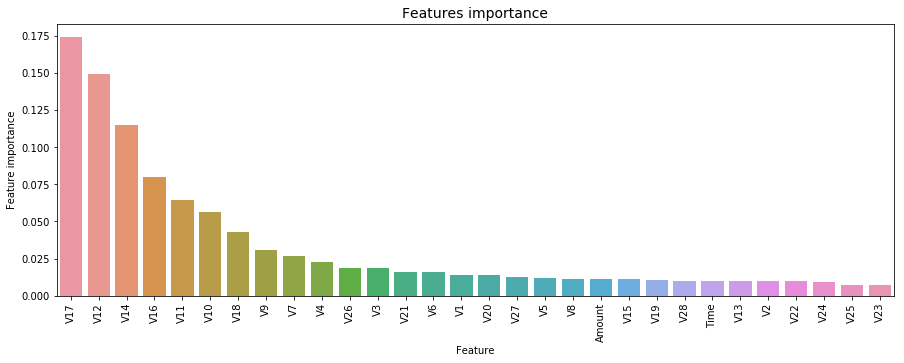

In [126]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,5))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

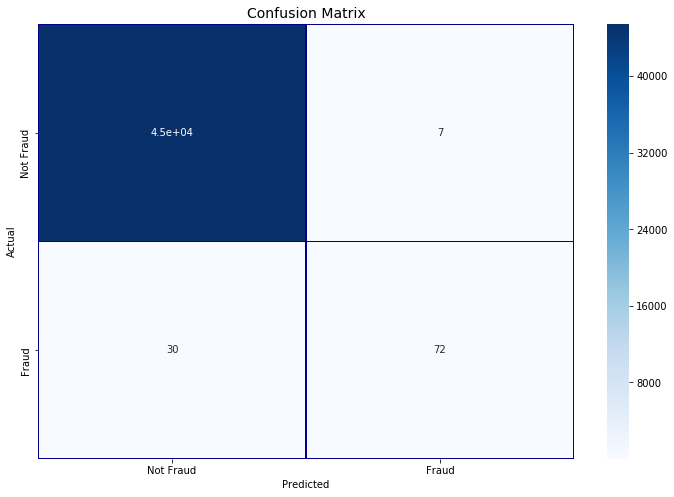

In [127]:
cm = pd.crosstab(valid_df[target].values, rf_preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(12,8))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [128]:
roc_auc_score(valid_df[target].values, rf_preds)

0.8528641975628091

In [ ]:
# Algorithm 4: LightGBM

In [136]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [137]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [138]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.97289	valid's auc: 0.967126
[100]	train's auc: 0.987513	valid's auc: 0.972525
[150]	train's auc: 0.988872	valid's auc: 0.93531
Early stopping, best iteration is:
[85]	train's auc: 0.987093	valid's auc: 0.974528


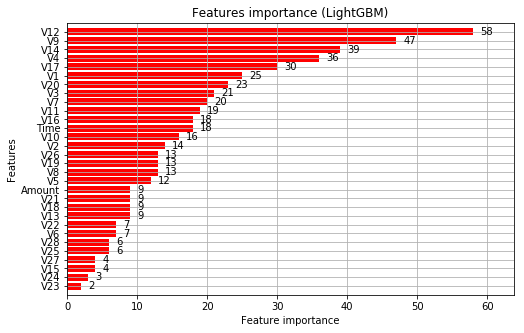

In [139]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

In [140]:
lgb_preds = model.predict(test_df[predictors])

In [141]:
roc_auc_score(test_df[target].values, lgb_preds)

0.9459470296507333

In [ ]:
# Algorithm 4: XGBoost

In [76]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [77]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.887798	valid-auc:0.85275
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.939458	valid-auc:0.881985
[100]	train-auc:0.945599	valid-auc:0.895288
[150]	train-auc:0.979799	valid-auc:0.967425
[200]	train-auc:0.988671	valid-auc:0.981864
[250]	train-auc:0.993822	valid-auc:0.984559
[300]	train-auc:0.996167	valid-auc:0.983335
Stopping. Best iteration:
[274]	train-auc:0.995133	valid-auc:0.984998



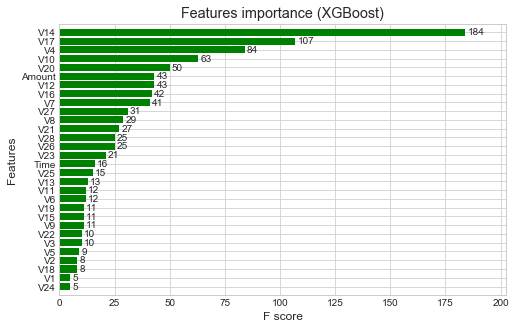

In [78]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [80]:
preds = model.predict(dtest)
roc_auc_score(test_df[target].values, preds)

0.977164714572122

In [ ]:
#SECTION 2: OVERSAMPLING, UNDERSAMPLING AND SMOTE TO HANDLE CLASS IMBALANCE

In [172]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [173]:
#Normalize amount variable
data_df["Normalized_Amount"] = StandardScaler().fit_transform(data_df['Amount'].values.reshape(-1, 1))
df = data_df.drop(['Time', 'Amount'], axis = 1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Normalized_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [164]:
Class = [len(df.loc[df.Class == 1]), len(df.loc[df.Class == 0])]
pd.Series(Class, index = ['Fraudulent', 'Non-fraudulent'], name = 'target')

Fraudulent           492
Non-fraudulent    284315
Name: target, dtype: int64

In [165]:
#Percentage of minority(fraudulent) class
print('% of Fraudulent Class = {:.3f}%'.format(len(df[df.Class == 1])*100 / len(df)))

% of Fraudulent Class = 0.173%


In [174]:
def results(balancing_technique):
    print(balancing_technique)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
    model_name = ["RF", "XGB", "LGB"]
    RFC = RandomForestClassifier(random_state = 0)
    XGBC = XGBClassifier(random_state = 0)
    LGBC = LGBMClassifier(random_state = 0)

    for clf,i in zip([RFC, XGBC, LGBC], model_name):
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        print("#"*25,i,"#"*25)
        print("Training Accuracy = {:.3f}".format(model.score(X_train, y_train)))
        print("Test Accuracy = {:.3f}".format(model.score(X_test, y_test)))
        print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_pred)))
        #Confusion Matrix
        print(confusion_matrix(y_test, y_pred))
        print("-"*15,"CLASSIFICATION REPORT","-"*15)
        print(classification_report(y_test, y_pred))
        
        #precision-recall curve
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
        avg_pre = average_precision_score(y_test, y_pred_prob)
        ax1.plot(precision, recall, label = i+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
        ax1.set_xlabel('Precision', fontsize = 14)
        ax1.set_ylabel('Recall', fontsize = 14)
        ax1.set_title('Precision-Recall Curve', fontsize = 18)
        ax1.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_pr - 0.5))
        ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

        #roc-curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr,tpr)
        ax2.plot(fpr,tpr, label = i+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
        ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
        ax2.set_xlabel("False Positive Rate", fontsize = 14)
        ax2.set_ylabel("True Positive Rate", fontsize = 14)
        ax2.set_title("ROC Curve", fontsize = 18)
        ax2.legend(loc = 'best')
       
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_roc - 0.5))
        ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
        plt.tight_layout()

In [175]:
X = df.drop(columns = 'Class')
y = df['Class']
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Without Balancing
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.867306
[[85289     7]
 [   39   108]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.94      0.73      0.82       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.97      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.880900
[[85287     9]
 [   35   112]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.93      0.76      0.84       147

   micro avg       1.00      1.00      1.00     85443
   macro a

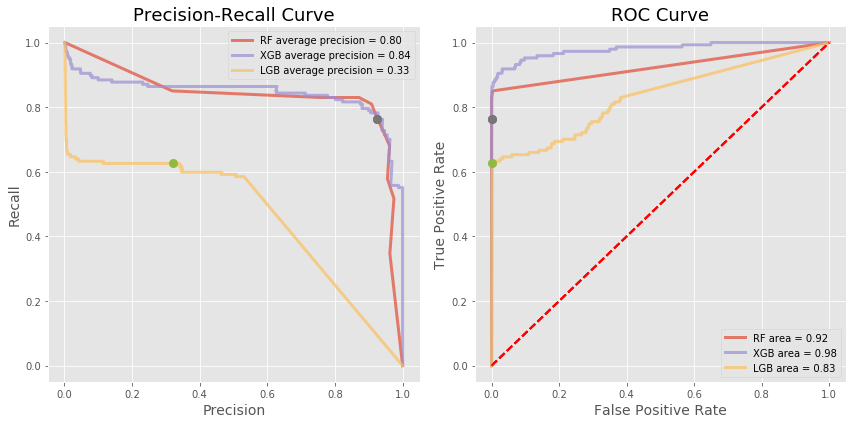

In [176]:
results("Without Balancing")

In [ ]:
# Method 1: Downsampling Majority Class

In [177]:
print("Minority Class =", len(df[df.Class == 1]))

Minority Class = 492


In [178]:
train_majority = df[df.Class == 0]
train_minority = df[df.Class == 1]
train_majority_downsampled = resample(train_majority, replace = False, n_samples = 492, random_state = 0)
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

In [179]:
X = train_downsampled.drop(columns = 'Class')
y = train_downsampled['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Down Sampling
######################### RF #########################
Training Accuracy = 0.993
Test Accuracy = 0.922
ROC_AUC_score : 0.922545
[[141   6]
 [ 17 132]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       147
           1       0.96      0.89      0.92       149

   micro avg       0.92      0.92      0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296

######################### XGB #########################
Training Accuracy = 0.999
Test Accuracy = 0.939
ROC_AUC_score : 0.939369
[[142   5]
 [ 13 136]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       147
           1       0.96      0.91      0.94       149

   micro avg       0.94      0.94      0.94       296
   macro avg       0.94      0

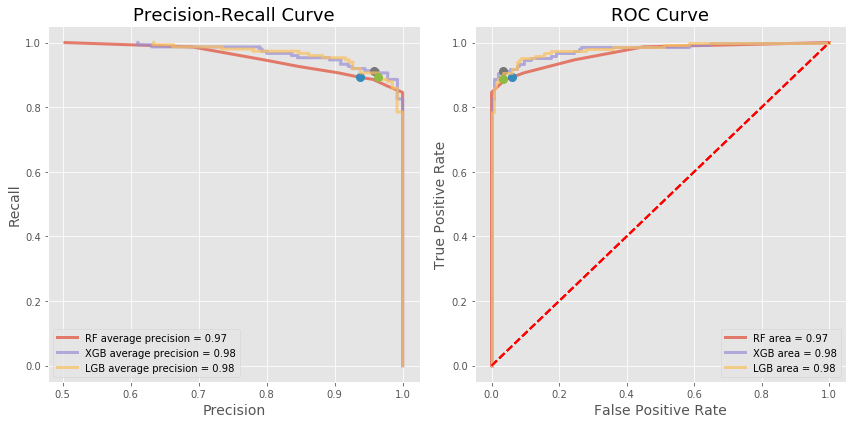

In [180]:
results("Down Sampling")

In [ ]:
# Result: All models performed well but the main disadvantage of down sampling is that it will lose a lot of useful information from the dataset as it is removing more than 99% of non-fraudulent cases from the dataset. Thus, this should not be a practical approach here.

In [ ]:
# METHOD 2 : UPSAMPLING

In [181]:
#Note in up sampling, first split the minority class data into train and test set and then up-sample the train data and test it with test data
X = df.drop(columns = 'Class')
y = df['Class']
#First split data into train and test
X_train_us, X_test, y_train_us, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
#Now resample the train data
df_us = pd.concat([X_train_us, y_train_us], axis = 1)
train_majority = df_us[df_us.Class == 0]
train_minority = df_us[df_us.Class == 1]
train_majority.shape, train_minority.shape

((199019, 30), (345, 30))

In [182]:
train_minority_upsampled = resample(train_minority, replace = True, n_samples = 199019, random_state = 0)
print(train_majority.shape, train_minority_upsampled.shape)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
X_train = train_upsampled.drop(columns = 'Class')
y_train = train_upsampled['Class']

(199019, 30) (199019, 30)


Up Sampling
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 1.000
ROC_AUC_score : 0.877528
[[85292     4]
 [   36   111]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.97      0.76      0.85       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.998
Test Accuracy = 0.996
ROC_AUC_score : 0.933346
[[84950   346]
 [   19   128]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.27      0.87      0.41       147

   micro avg       1.00      1.00      1.00     85443
   macro avg    

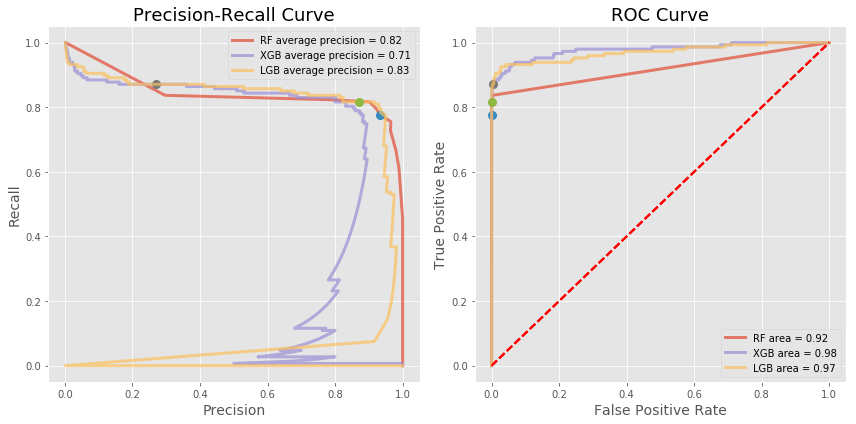

In [183]:
results("Up Sampling")

In [ ]:
#Surprisingly, threshold of XGB is very earlier. But, PR curves resembles same as other models. This means using up sampling, XGB performs well on recall but precision is decreased. I mean that XGB classified less FN and more FP with more than 50% probability. Thus, this increases the recall of XGB.
#Further looking at PR curves, we can say that all models performes well. As per requirement, one can set threshold and get the required result.

In [ ]:
# Method 3: SMOTE Regular

In [184]:
sm = SMOTE(random_state = 0)
X = df.drop(columns = 'Class')
y = df['Class']
X_train_sm, X_test, y_train_sm, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, y_train = sm.fit_sample(X_train_sm, y_train_sm)
X_test = np.array(X_test)
y_test = np.array(y_test)

SMOTE Regular
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.891092
[[85285    11]
 [   32   115]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.91      0.78      0.84       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.96      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.986
Test Accuracy = 0.991
ROC_AUC_score : 0.934127
[[84503   793]
 [   18   129]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85296
           1       0.14      0.88      0.24       147

   micro avg       0.99      0.99      0.99     85443
   macro avg  

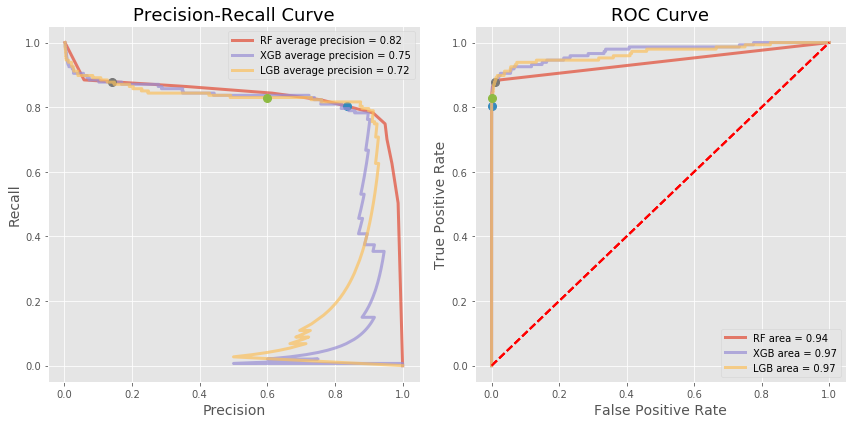

In [185]:
results("SMOTE Regular")

In [ ]:
#Applying SMOTE, RF performed very well.
#Looking at ROC-AUC curve, boosting performed well. But in real, I will consider RF performing well as compared to boosting methods because RF maintained precision as compared to boosting .

In [ ]:
# Method 4: Borderline SMOTE

In [186]:
sm = BorderlineSMOTE(random_state = 0)
X = df.drop(columns = 'Class')
y = df['Class']
X_train_sm, X_test, y_train_sm, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, y_train = sm.fit_sample(X_train_sm, y_train_sm)
X_test = np.array(X_test)
y_test = np.array(y_test)

Borderline SMOTE
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.884301
[[85287     9]
 [   34   113]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.93      0.77      0.84       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.96      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.999
Test Accuracy = 0.998
ROC_AUC_score : 0.920843
[[85138   158]
 [   23   124]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.44      0.84      0.58       147

   micro avg       1.00      1.00      1.00     85443
   macro av

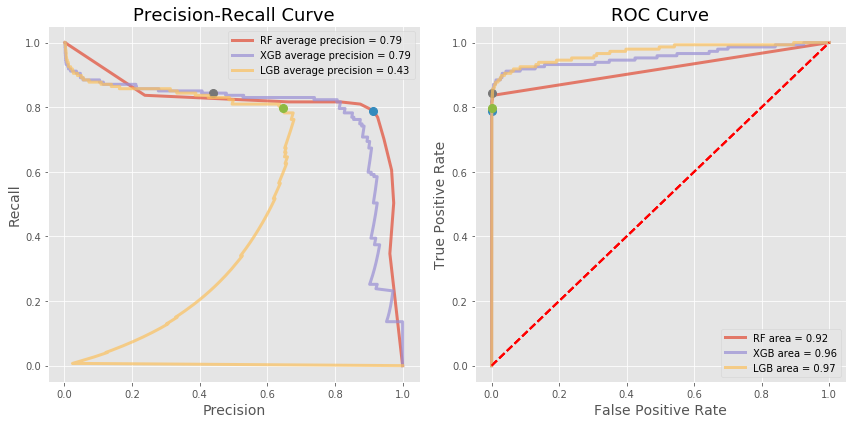

In [187]:
results("Borderline SMOTE")

In [ ]:
# Applying Borderline SMOTE, again RF gave high F1-score.
# Surprisingly, LGB performed worst looking at PR curves and best according to ROC.

In [ ]:
# Method 5: ADASYN (ADASYN = SMOTE + random values between 0 and 1. This makes dataset somewhat more robust)

In [188]:
adasyn = ADASYN(random_state = 0)
X = df.drop(columns = 'Class')
y = df['Class']
X_train_as, X_test, y_train_as, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, y_train = adasyn.fit_sample(X_train_as, y_train_as)
X_test = np.array(X_test)
y_test = np.array(y_test)

ADASYN
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.887650
[[85278    18]
 [   33   114]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.86      0.78      0.82       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.93      0.89      0.91     85443
weighted avg       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.980
Test Accuracy = 0.971
ROC_AUC_score : 0.931334
[[82866  2430]
 [   16   131]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85296
           1       0.05      0.89      0.10       147

   micro avg       0.97      0.97      0.97     85443
   macro avg       0.

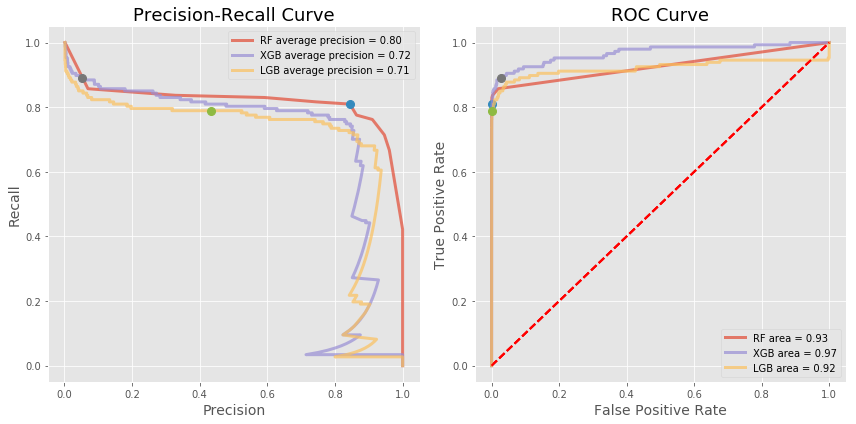

In [189]:
results("ADASYN")

In [ ]:
#RESULTS & CONCLUSIONS:
#ROC curve for all three models were almost same. PR curve however differentiated somewhat performance based on precision.
#Random forest performed best when data was balanced with different techniques as it maintained recall and precision with the default threshold and maintained precision as compared to boosting as the threshold was decreasing.
#For imbalanced data XGB performed slightly well as compared to RF.
#For balanced data, boosting made predictions with high recall and compromising precision and RF made predictions based on both recall and precision.
# From PR curves, one can say that models performed well and almost same with SMOTE Regular. User can set threshold to obtain the required result as per the business goal.

In [ ]:
# Algorithm 5: Autoencoders

In [83]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


In [85]:
from sklearn.preprocessing import StandardScaler

data = data_df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [87]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [88]:
X_train.shape

(227451, 29)

In [ ]:
# This Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. 
# Additionally, L1 regularization will be used during training:

In [89]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [90]:

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [91]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.8342 - acc: 0.5621 - val_loss: 0.8105 - val_acc: 0.6183
Epoch 2/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.7714 - acc: 0.6172 - val_loss: 0.7960 - val_acc: 0.6127
Epoch 3/100
227451/227451 [==============================] - 9s 38us/step - loss: 0.7617 - acc: 0.6228 - val_loss: 0.7949 - val_acc: 0.6170
Epoch 4/100
227451/227451 [==============================] - 8s 34us/step - loss: 0.7546 - acc: 0.6292 - val_loss: 0.7853 - val_acc: 0.6299
Epoch 5/100
227451/227451 [==============================] - 8s 37us/step - loss: 0.7508 - acc: 0.6308 - val_loss: 0.7817 - val_acc: 0.6322
Epoch 6/100
227451/227451 [==============================] - 8s 35us/step - loss: 0.7489 - acc: 0.6329 - val_loss: 0.7822 - val_acc: 0.6342
Epoch 7/100
227451/227451 [==============================] - 9s 38us/step - loss: 0.7471 - acc: 0.6351 - val_

Epoch 59/100
227451/227451 [==============================] - 8s 34us/step - loss: 0.7351 - acc: 0.6553 - val_loss: 0.7724 - val_acc: 0.6538
Epoch 60/100
227451/227451 [==============================] - 8s 34us/step - loss: 0.7351 - acc: 0.6560 - val_loss: 0.7774 - val_acc: 0.6401
Epoch 61/100
227451/227451 [==============================] - 8s 34us/step - loss: 0.7350 - acc: 0.6559 - val_loss: 0.7757 - val_acc: 0.6466
Epoch 62/100
227451/227451 [==============================] - 9s 37us/step - loss: 0.7351 - acc: 0.6565 - val_loss: 0.7729 - val_acc: 0.6441
Epoch 63/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.7353 - acc: 0.6557 - val_loss: 0.7738 - val_acc: 0.6576
Epoch 64/100
227451/227451 [==============================] - 8s 37us/step - loss: 0.7351 - acc: 0.6551 - val_loss: 0.7691 - val_acc: 0.6639
Epoch 65/100
227451/227451 [==============================] - 10s 42us/step - loss: 0.7351 - acc: 0.6559 - val_loss: 0.7701 - val_acc: 0.6594
Epoch 66/100

In [92]:
autoencoder = load_model('model.h5')

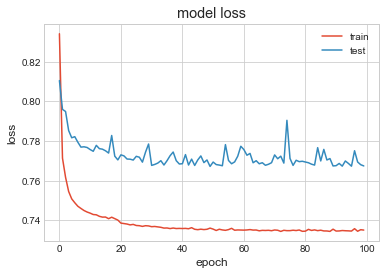

In [93]:

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [94]:
predictions = autoencoder.predict(X_test)

In [95]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [96]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.760177,0.001720
std,3.429886,0.041443
min,0.033328,0.000000
25%,0.250108,0.000000
50%,0.404649,0.000000
75%,0.672947,0.000000
max,271.665036,1.000000


In [44]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

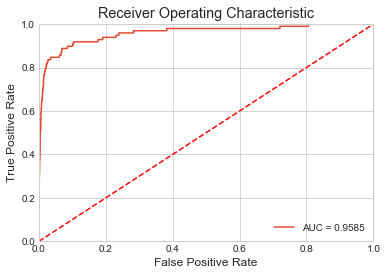

In [98]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

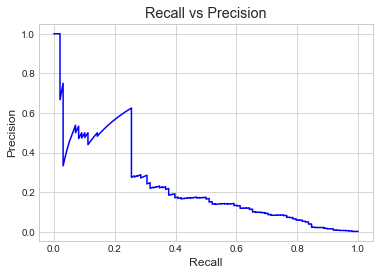

In [99]:

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

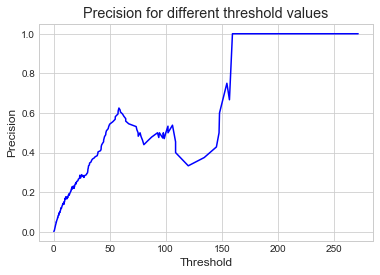

In [100]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

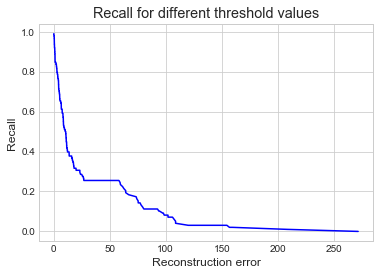

In [101]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [80]:
threshold = 5

In [81]:

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

NameError: name 'error_df' is not defined

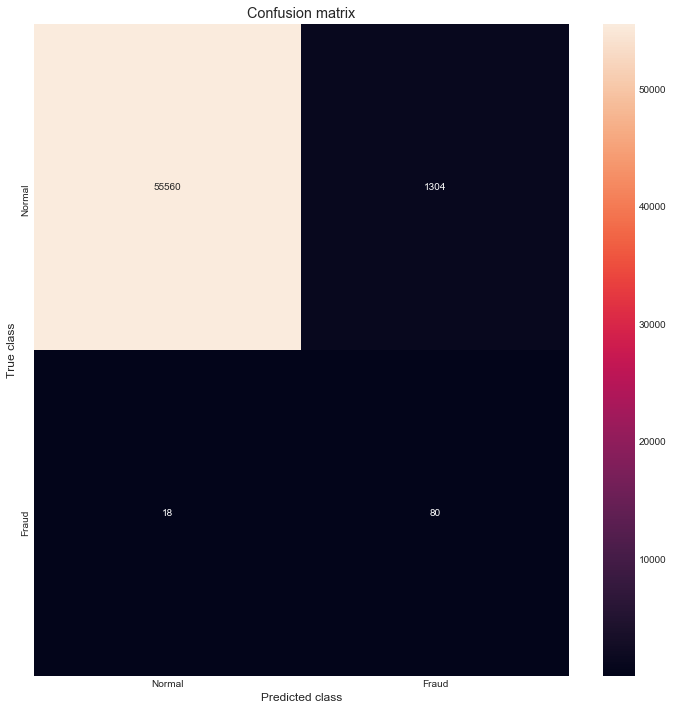

In [105]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [38]:
# Unspervised Anomoly Detection Algorithms

In [39]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [60]:
inliers = data_df[data_df.Class==0]
inliers = inliers.drop(['Class'], axis=1)
outliers = data_df[data_df.Class==1]
outliers = outliers.drop(['Class'], axis=1)
outlier_fraction = len(outliers)/float(len(inliers))

inliers_train, inliers_test = train_test_split(inliers, test_size=0.30, random_state=1)

In [59]:
# Local Outlier Factor

In [62]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(novelty=True)
model.fit(inliers_train)
inlier_pred_test = model.predict(inliers_test)
outlier_pred = model.predict(outliers)

In [64]:
print("Accuracy in Detecting Legit Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Detecting Fraud Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Detecting Legit Cases: 0.8931238642358872
Accuracy in Detecting Fraud Cases: 0.44308943089430897


In [65]:
lof_predictions= model.predict((data_df.drop(['Class'], axis=1)))
lof_score = model.score_samples((data_df.drop(['Class'], axis=1)))

In [66]:
lof_predictions = pd.DataFrame({
    "predicted_class": list(map(lambda x: 1*(x == -1), lof_predictions)),
    "class": data_df["Class"],
    "predict": -lof_score
})

lof_predictions.head()

,class,predict,predicted_class
0,0,1.731484,1
1,0,1.418396,1
2,0,2.290177,1
3,0,1.850644,1
4,0,2.191428,1


In [67]:
%matplotlib inline 
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np


def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate",
                "True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate",
                "True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall",
                "Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = sum(labels)/len(labels)
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall",
                "Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes


def figure():
    fig_size = 8
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)


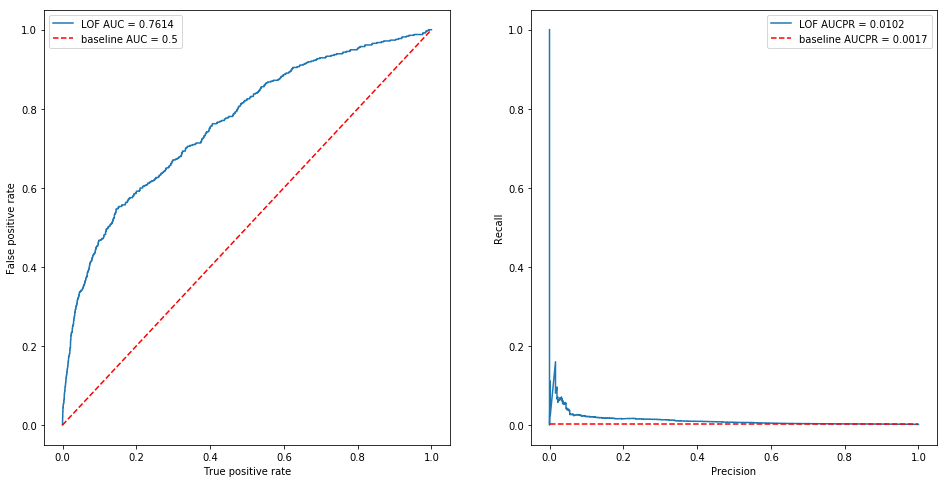

In [72]:
figure()
axes = prediction_summary(
    lof_predictions["class"], lof_predictions["predict"], "LOF")

In [ ]:
# Isolation Forest

In [73]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [74]:
model = IsolationForest()
model.fit(data_df.drop(['Class'], axis=1))
inlier_pred_test = model.predict(inliers_test)
outlier_pred = model.predict(outliers)

In [75]:
print("Accuracy in Detecting Legit Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Detecting Fraud Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Detecting Legit Cases: 0.9008734392402837
Accuracy in Detecting Fraud Cases: 0.8882113821138211


In [76]:
iso_predictions= model.predict((data_df.drop(['Class'], axis=1)))
iso_score = model.score_samples((data_df.drop(['Class'], axis=1)))

In [77]:
iso_predictions = pd.DataFrame({
    "predicted_class": list(map(lambda x: 1*(x == -1), iso_predictions)),
    "class": data_df["Class"],
    "predict": -iso_score
})

iso_predictions.head()

,class,predict,predicted_class
0,0,0.383966,0
1,0,0.362661,0
2,0,0.459612,1
3,0,0.396753,0
4,0,0.395990,0


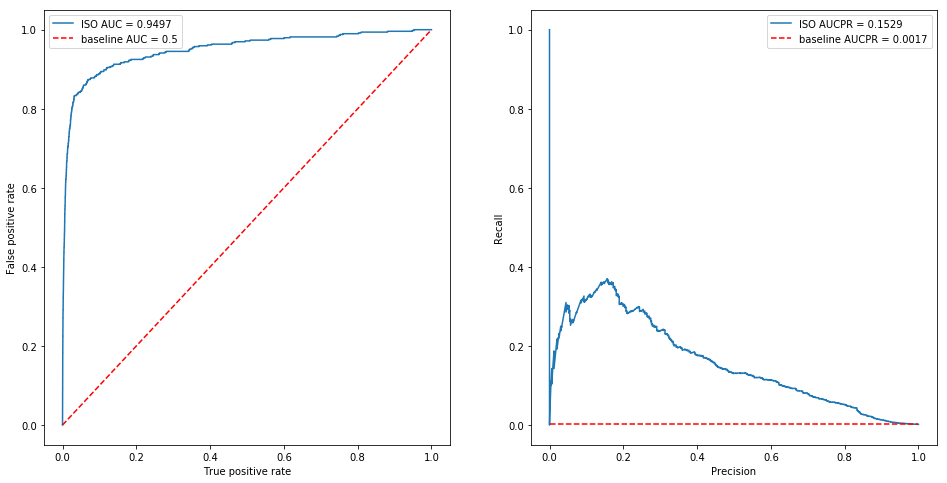

In [78]:
figure()
axes = prediction_summary(
    iso_predictions["class"], iso_predictions["predict"], "ISO")